# Gym crowdedness project

<m>

## 1. Data wrangling and preparation

<m>

### 1.1 Import and read data

<m>

In [96]:
import pandas as pd
import numpy as np
import janitor as janitor
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from scipy import stats
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import psycopg2
import mysql.connector
import re
import ast
import openpyxl
import pyarrow
from fuzzywuzzy import fuzz,process
import geopandas as gpd
import warnings as warnings
warnings.filterwarnings('ignore')
plt.style.use('bmh')
%matplotlib inline

In [2]:
df=pd.read_excel('Gym Crowdedness.xlsx')

In [3]:
df.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,0,2015-08-15 00:00:10-07:00,1900-01-10 00:00:00,5,1,0,66.76,0,0,August,0
1,1,2015-08-15 00:20:08-07:00,1903-04-22 00:00:00,5,1,0,66.76,0,0,August,0
2,0,2015-08-15 00:30:09-07:00,1904-12-13 00:00:00,5,1,0,66.76,0,0,August,0
3,0,2015-08-15 00:40:10-07:00,1906-08-06 00:00:00,5,1,0,66.76,0,0,August,0
4,0,2015-08-15 00:50:13-07:00,1908-03-31 00:00:00,5,1,0,66.76,0,0,August,0


<m>

### 1.2 Understanding data

<m>

In [4]:
report=ydp.ProfileReport(df)
report.to_file("profiling report.html")

In [5]:
report=sv.analyze(df)
report.show_html('Profilling Report.html')

In [6]:
df.shape

(30024, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30024 entries, 0 to 30023
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         30024 non-null  int64  
 1   date                  30024 non-null  object 
 2   timestamp             30024 non-null  object 
 3   day_of_week           30024 non-null  int64  
 4   is_weekend            30024 non-null  int64  
 5   is_holiday            30024 non-null  int64  
 6   temperature           30024 non-null  float64
 7   is_start_of_semester  30024 non-null  int64  
 8   is_during_semester    30024 non-null  int64  
 9   month                 30024 non-null  object 
 10  hour                  30024 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 2.5+ MB


In [8]:
df.describe()

,number_people,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,hour
count,30024.000000,30024.000000,30024.000000,30024.000000,30024.000000,30024.000000,30024.000000,30024.000000
mean,17.520517,2.985745,0.282874,0.002498,56.962464,0.077205,0.644718,6.296263
std,18.119834,1.992775,0.450403,0.049918,5.790329,0.266921,0.478607,3.682544
min,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,54.120000,0.000000,0.000000,3.000000
50%,14.000000,3.000000,0.000000,0.000000,57.230000,0.000000,1.000000,7.000000
75%,30.000000,5.000000,1.000000,0.000000,60.470000,0.000000,1.000000,9.000000
max,85.000000,6.000000,1.000000,1.000000,81.810000,1.000000,1.000000,12.000000


In [9]:
df.dtypes

number_people             int64
date                     object
timestamp                object
day_of_week               int64
is_weekend                int64
is_holiday                int64
temperature             float64
is_start_of_semester      int64
is_during_semester        int64
month                    object
hour                      int64
dtype: object

In [10]:
df.index

RangeIndex(start=0, stop=30024, step=1)

In [11]:
df.duplicated().sum()

0

In [12]:
df.isnull().sum()

number_people           0
date                    0
timestamp               0
day_of_week             0
is_weekend              0
is_holiday              0
temperature             0
is_start_of_semester    0
is_during_semester      0
month                   0
hour                    0
dtype: int64

<m>

### 1.3 Preparing data

<m>

In [13]:
df.columns

Index(['number_people', 'date', 'timestamp', 'day_of_week', 'is_weekend',
       'is_holiday', 'temperature', 'is_start_of_semester',
       'is_during_semester', 'month', 'hour'],
      dtype='object')

In [14]:
df.drop('month',axis=1,inplace=True)

In [15]:
df["temperature"]=round(df["temperature"],0)

In [16]:
df["temperature"]=df["temperature"].astype(int)

In [17]:
df["temperature"].dtype

dtype('int32')

In [18]:
df["date"].unique()

array(['2015-08-15 00:00:10-07:00', '2015-08-15 00:20:08-07:00',
       '2015-08-15 00:30:09-07:00', ..., '2017-03-18 12:08:49-07:00',
       '2017-03-18 12:18:51-07:00', '2017-03-18 12:28:53-07:00'],
      dtype=object)

In [19]:
df['date'] = pd.to_datetime(df['date'], utc=True)

In [20]:
try:
    pd.to_datetime(df["date"])
    print("Valid datetime format")
except ValueError:
    print("Invalid datetime format")

Valid datetime format


In [21]:
df['date'].dtype

datetime64[ns, UTC]

In [22]:
df['date'] = df['date'].dt.date

In [23]:
df.drop('timestamp',axis=1,inplace=True)

<m>

### 1.3.1 Dealing with outliers

##### Z-Score and IQR

<m>

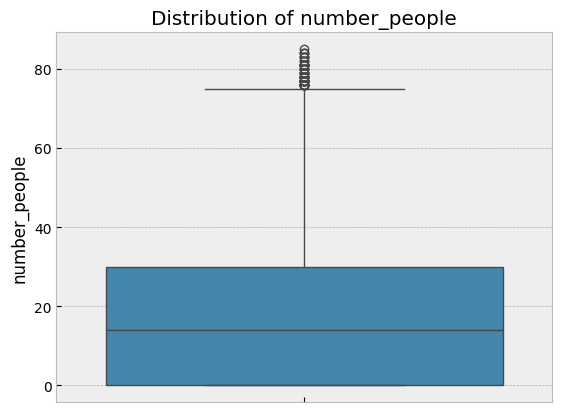

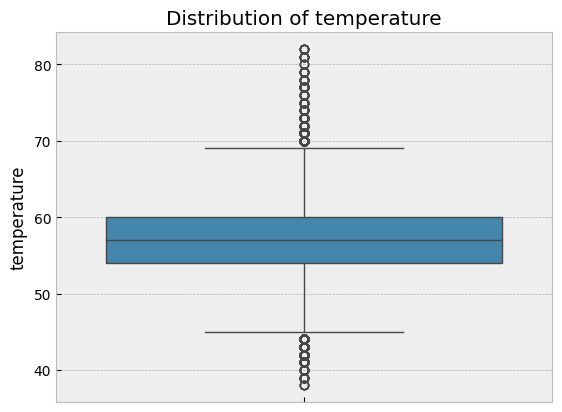

In [24]:
for column in['number_people','temperature']:
    sns.boxplot(df[column])
    plt.title(f'Distribution of {column}')
    plt.show()

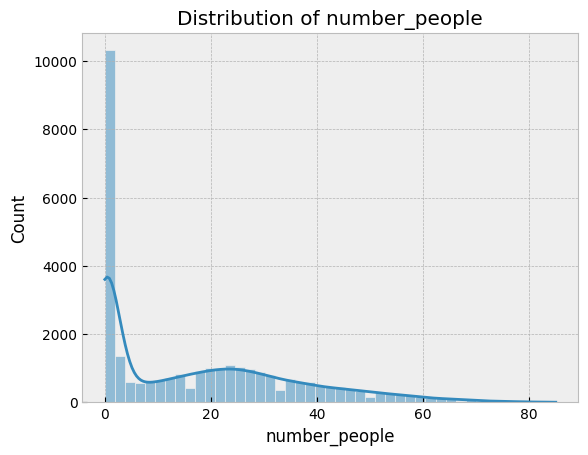

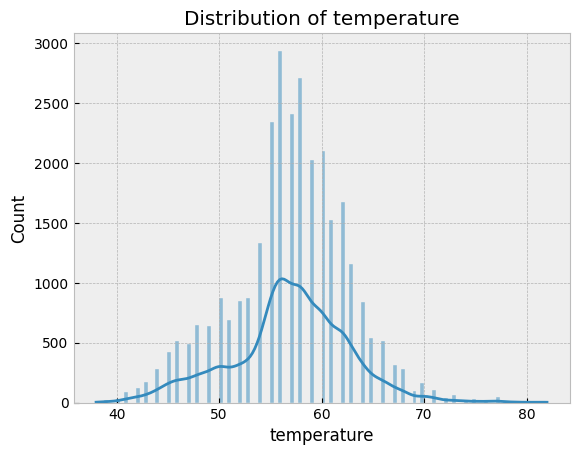

In [25]:
for column in['number_people','temperature']:
    sns.histplot(df[column],kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

In [26]:
df[['number_people','temperature']].skew()

number_people    0.836087
temperature     -0.101976
dtype: float64

<m>

##### Z-Score

<m>

In [27]:
def z_score_outliers_sample(df, column):
    upper_limit = df[column].mean() + 3 * df[column].std()
    lower_limit = df[column].mean() - 3 * df[column].std()
    pd.set_option('display.max_rows',None)
    return df[(df[column] > upper_limit) | (df[column] < lower_limit)].head()

In [28]:
def z_score_outliers_population(df, column):
    upper_limit = df[column].mean() + 3 * df[column].std()
    lower_limit = df[column].mean() - 3 * df[column].std()
    pd.set_option('display.max_rows',None)
    return df[(df[column] > upper_limit) | (df[column] < lower_limit)]

In [29]:
def z_score_outliers_values(column):
    upper_limit=column.mean()+3*column.std()
    lower_limit=column.mean()-3*column.std()
    print(f'Upper Limit = {upper_limit}\nLower Limit = {lower_limit}')

##### Temperature - Z-Score

In [30]:
z_score_outliers_values(df['temperature'])

Upper Limit = 74.36950355198647
Lower Limit = 39.54716311468021


In [31]:
df['temperature'].max()

82

In [32]:
df['temperature'].min()

38

In [33]:
z_score_outliers_sample(df,'temperature')

,number_people,date,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,hour
40,36,2015-08-15,5,1,0,77,0,0,12
41,37,2015-08-15,5,1,0,77,0,0,12
42,38,2015-08-15,5,1,0,77,0,0,12
73,23,2015-08-16,6,1,0,75,0,0,10
74,27,2015-08-16,6,1,0,75,0,0,10


In [34]:
temp_outliers=z_score_outliers_population(df,'temperature')

In [35]:
temp_outliers.sort_values(by='temperature',ascending=False).head(5)

,number_people,date,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,hour
21362,27,2016-09-25,6,1,0,82,0,1,12
21363,26,2016-09-25,6,1,0,82,0,1,12
21358,17,2016-09-25,6,1,0,82,0,1,11
21359,28,2016-09-25,6,1,0,82,0,1,11
21360,25,2016-09-25,6,1,0,82,0,1,11


##### Temperature has no outliers because the range of temperature is very normal

<m>

##### IQR

<m>

In [36]:
def IQR_outliers_sample(df,column):
    q1=df[column].quantile(0.25)
    q3=df[column].quantile(0.75)
    iqr=q3-q1
    lower_bond=q1-1.5*iqr
    upper_bond=q3+1.5*iqr
    return df[(df[column]>upper_bond) | (df[column]<lower_bond)].head()

In [37]:
def IQR_outliers_population(df,column):
    q1=df[column].quantile(0.25)
    q3=df[column].quantile(0.75)
    iqr=q3-q1
    lower_bond=q1-1.5*iqr
    upper_bond=q3+1.5*iqr
    return df[(df[column]>upper_bond) | (df[column]<lower_bond)].head()

In [38]:
def iqr_outliers_values(df,column):
    q1=df[column].quantile(0.25)
    q3=df[column].quantile(0.75)
    iqr=q3-q1
    upper_bond=q3+1.5*iqr
    lower_bond=q1-1.5*iqr
    print(f'Upper bond = {upper_bond}\nLower bond = {lower_bond}')

In [39]:
iqr_outliers_values(df,'number_people')

Upper bond = 75.0
Lower bond = -45.0


In [40]:
df['number_people'].max()

85

In [41]:
df['number_people'].min()

0

In [42]:
IQR_outliers_sample(df,'number_people')

,number_people,date,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,hour
437,84,2015-08-25,1,0,0,64,0,0,11
443,77,2015-08-25,1,0,0,65,0,0,12
474,78,2015-08-26,2,0,0,63,1,1,9
479,76,2015-08-26,2,0,0,64,1,1,10
480,80,2015-08-26,2,0,0,66,1,1,11


In [43]:
no_outliers=IQR_outliers_population(df,'number_people')

In [44]:
no_outliers.sort_values(by='number_people',ascending=False).head(5)

,number_people,date,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,hour
437,84,2015-08-25,1,0,0,64,0,0,11
480,80,2015-08-26,2,0,0,66,1,1,11
474,78,2015-08-26,2,0,0,63,1,1,9
443,77,2015-08-25,1,0,0,65,0,0,12
479,76,2015-08-26,2,0,0,64,1,1,10


##### No.people has no outliers because the range is normal and is not far from the upper bond or the lower bond

<m>

### 1.3.2 Formating and adding columns

<m>

##### day name

In [45]:
df['day_name']='undifiend'

In [46]:
for index,row in df.iterrows():
    if row['day_of_week']==0:
        df.loc[index,'day_name']='Sunday'
    elif row['day_of_week']==1:
        df.loc[index,'day_name']='Monday' 
    elif row['day_of_week']==2:
        df.loc[index,'day_name']='Tuesday'
    elif row['day_of_week']==3:
        df.loc[index,'day_name']='Wednesday'   
    elif row['day_of_week']==4:
        df.loc[index,'day_name']='Thursday'
    elif row['day_of_week']==5:
        df.loc[index,'day_name']='Friday'
    elif row['day_of_week']==6:
        df.loc[index,'day_name']='Saturday'   

##### holiday - weekend - start semester - during semester

In [47]:
df['holiday']='undifiend'

In [48]:
df['weekend']='undifiend'

In [49]:
df['start_semester']='undifiend'

In [50]:
df['during_semester']='undifiend'

In [51]:
def main(column,emp_column):
   for index,row in df.iterrows():
       if row[column]==0:
           df.loc[index,emp_column]='No'
       elif row[column]==1:
           df.loc[index,emp_column]='Yes'    

In [52]:
main('is_weekend','weekend')

In [53]:
main('is_holiday','holiday')

In [54]:
main('is_start_of_semester','start_semester')

In [55]:
main('is_during_semester','during_semester')

##### hour

In [56]:
df['hour 1']='undifiend'

In [57]:
for index,row in df.iterrows():
    if row['hour']==5:
        df.loc[index,'hour 1']='5AM'
    elif row['hour']==6:
        df.loc[index,'hour 1']='6AM' 
    elif row['hour']==7:
        df.loc[index,'hour 1']='7AM'
    elif row['hour']==8:
        df.loc[index,'hour 1']='8AM'   
    elif row['hour']==9:
        df.loc[index,'hour 1']='9AM'
    elif row['hour']==10:
        df.loc[index,'hour 1']='10AM'
    elif row['hour']==11:
        df.loc[index,'hour 1']='11AM'
    elif row['hour']==12:
        df.loc[index,'hour 1']='12PM'

In [58]:
df = df.query('`hour 1` != "undifiend"')

In [59]:
df.drop('hour',axis=1,inplace=True)

In [60]:
df.rename(columns={'hour 1':'hour'},inplace=True)

##### crowdedness status

In [61]:
df['crowdedness_status']='undifiend'

In [62]:
for index,row in df.iterrows():
    if row['number_people']<=25:
        df.loc[index,'crowdedness_status']='Not Crowded'
    elif row['number_people']<=50:
        df.loc[index,'crowdedness_status']='crowded' 
    elif row['number_people']>50:
        df.loc[index,'crowdedness_status']='Very Crowded'

##### season

In [63]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

In [64]:
df['season'] = df['date'].apply(get_season)

In [65]:
df['season'].unique()

array(['Summer', 'Fall', 'Winter', 'Spring'], dtype=object)

##### month

In [66]:
df['date'] = pd.to_datetime(df['date'])
df['month_name'] = df['date'].dt.month_name()

<m>

In [67]:
df.columns

Index(['number_people', 'date', 'day_of_week', 'is_weekend', 'is_holiday',
       'temperature', 'is_start_of_semester', 'is_during_semester', 'day_name',
       'holiday', 'weekend', 'start_semester', 'during_semester', 'hour',
       'crowdedness_status', 'season', 'month_name'],
      dtype='object')

In [68]:
new_order=['number_people','crowdedness_status','date','month_name','season','day_of_week','day_name','hour','temperature','is_weekend', 'is_holiday',
    'is_start_of_semester', 'is_during_semester',
       'holiday', 'weekend', 'start_semester', 'during_semester',]

In [69]:
df=df[new_order]

In [70]:
df.columns

Index(['number_people', 'crowdedness_status', 'date', 'month_name', 'season',
       'day_of_week', 'day_name', 'hour', 'temperature', 'is_weekend',
       'is_holiday', 'is_start_of_semester', 'is_during_semester', 'holiday',
       'weekend', 'start_semester', 'during_semester'],
      dtype='object')

In [71]:
df=df[['number_people', 'crowdedness_status', 'date', 'month_name', 'season',
       #'day_of_week'
       'day_name', 'hour', 'temperature', 'is_weekend',
       'is_holiday', 'is_start_of_semester', 'is_during_semester', 'holiday',
       'weekend', 'start_semester', 'during_semester']].copy()

In [72]:
df.rename(columns={'month_name':'month'},inplace=True)

<m>

### 1.4 Understanding features

##### (Univariant analysis)

##### Distribution of features

<m>

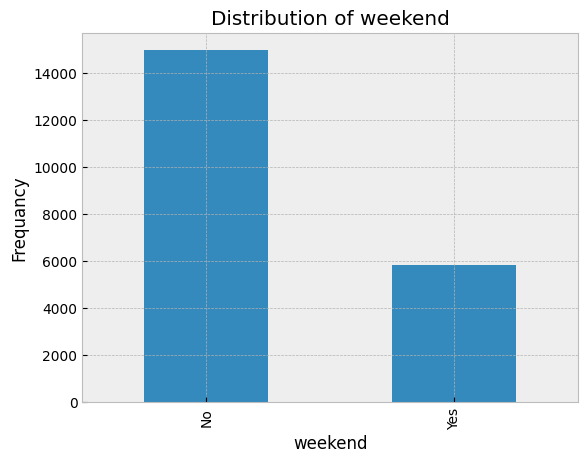

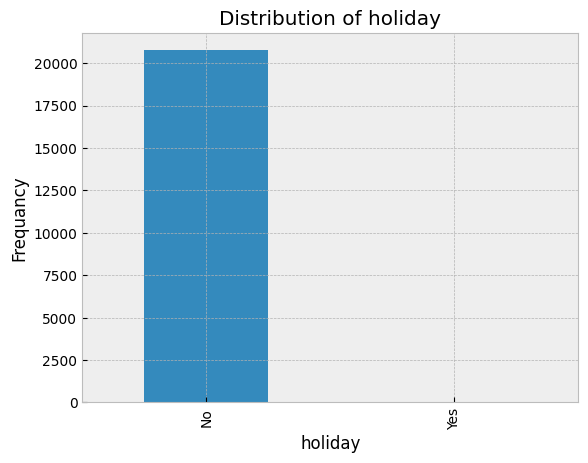

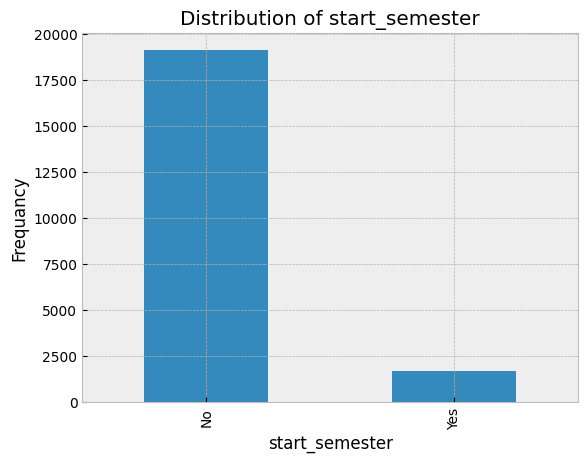

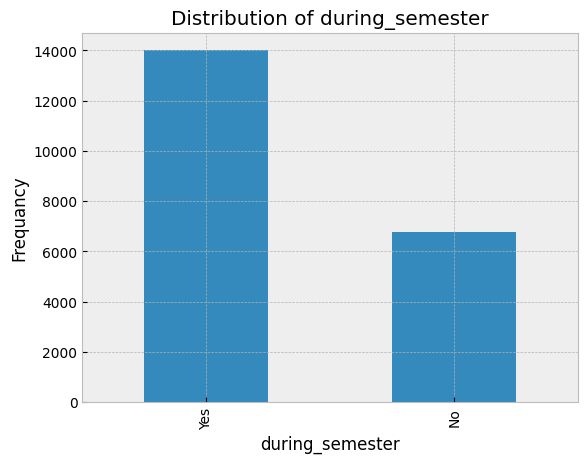

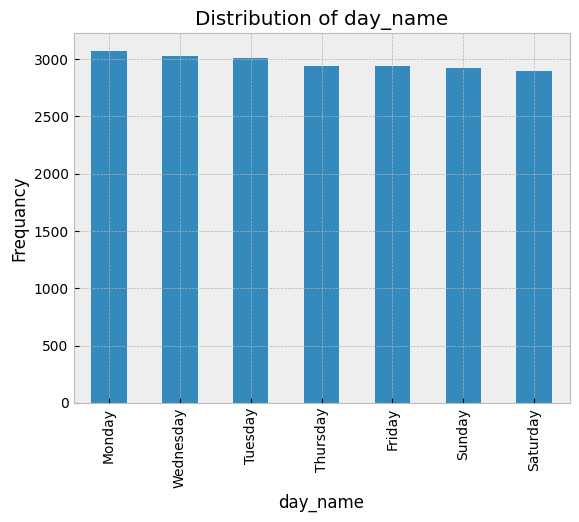

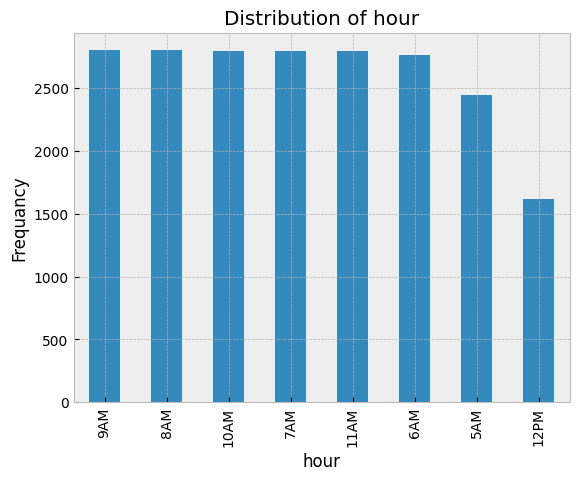

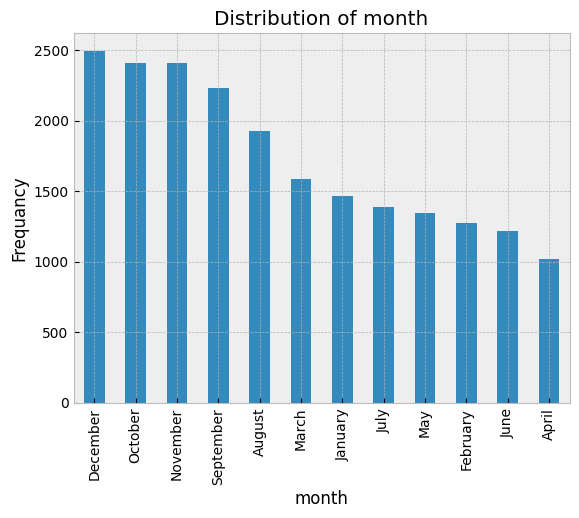

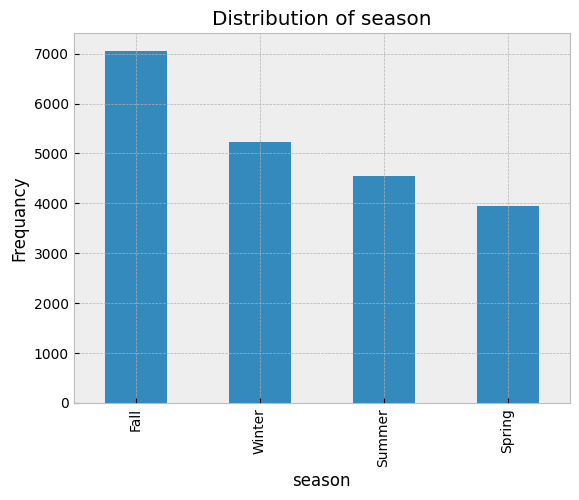

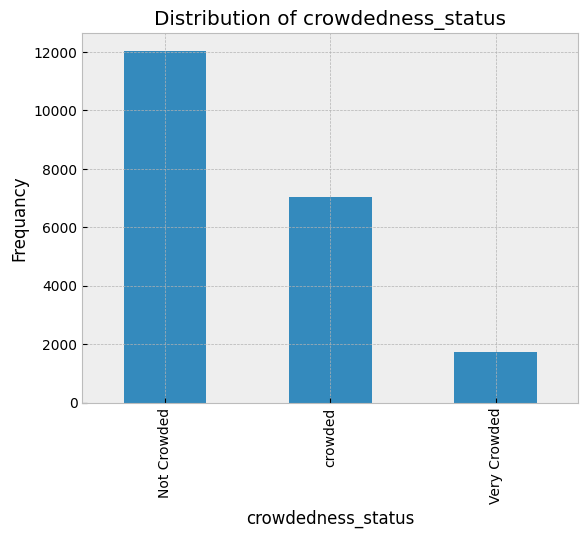

In [73]:
for column in ['weekend','holiday','start_semester','during_semester',
               'day_name','hour','month','season','crowdedness_status']:
    ax=df[column].value_counts().plot(kind='bar',title=f'Distribution of {column}')
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Frequancy')
    plt.show()

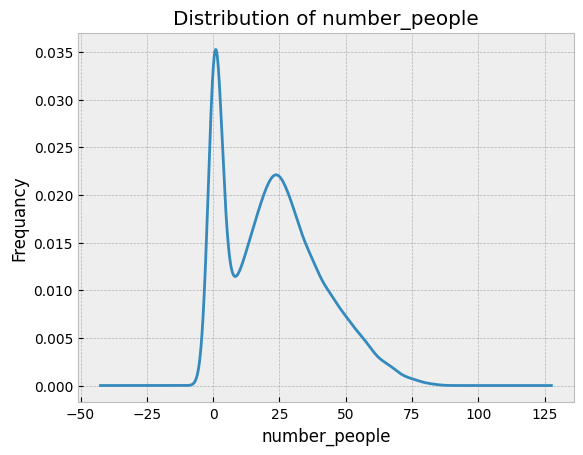

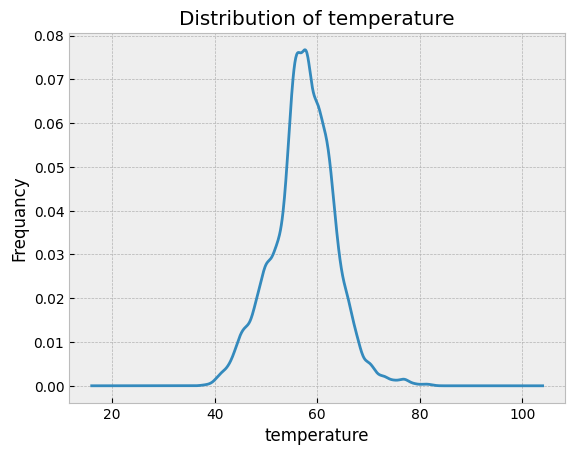

In [74]:
for column in ['number_people','temperature']:
    ax=df[column].plot(kind='kde',title=f'Distribution of {column}')
    ax.set_xlabel(f'{column}')
    ax.set_ylabel('Frequancy')
    plt.show()

<m>

### 1.5 Import to sql-server

<m>

In [ ]:
df_sql = df.copy()
df_sql.columns = [c.replace(" ", "_").replace("-", "_") for c in df_sql.columns]

In [ ]:
server = r'DESKTOP-KHP38V4'
database = 'Arizona_State_University_Gym'
driver = 'ODBC Driver 17 for SQL Server'
conn_str = (
    f"mssql+pyodbc://@{server}/{database}"
    f"?driver={driver.replace(' ', '+')}"
    "&trusted_connection=yes")
engine = create_engine(conn_str)
df_sql.to_sql('crowdedness_table', engine, if_exists='replace', index=False)

<m>

## 2. Analyzing data

### 2.1 Heatmap

<m>

In [75]:
numeric_columns=df.select_dtypes(include=['number'])

In [76]:
corr1=numeric_columns.corr()
corr1

,number_people,temperature,is_weekend,is_holiday,is_start_of_semester,is_during_semester
number_people,1.000000,0.390181,-0.208912,-0.049651,0.211254,0.325851
temperature,0.390181,1.000000,0.030718,-0.084284,0.104465,0.125386
is_weekend,-0.208912,0.030718,1.000000,-0.029071,-0.021830,-0.044327
is_holiday,-0.049651,-0.084284,-0.029071,1.000000,-0.013818,-0.066950
is_start_of_semester,0.211254,0.104465,-0.021830,-0.013818,1.000000,0.206396
is_during_semester,0.325851,0.125386,-0.044327,-0.066950,0.206396,1.000000


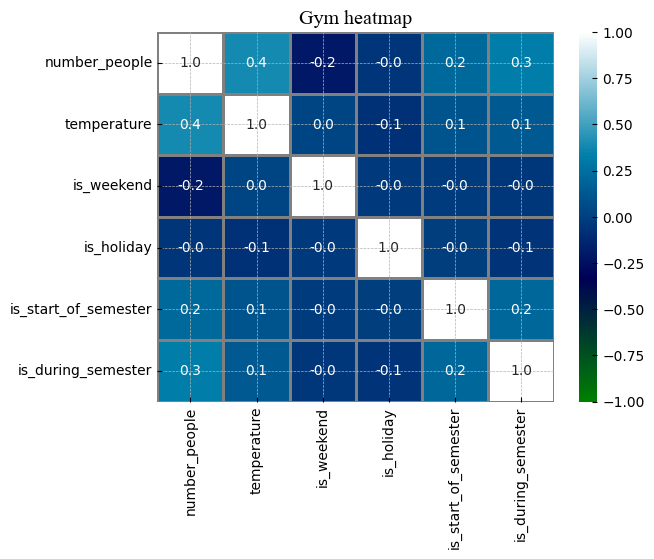

In [77]:
sns.heatmap(corr1,annot=True,vmax=1,vmin=-1,center=0,fmt='.1f',linecolor="grey",linewidth=1,cmap="ocean")
plt.title("Gym heatmap",fontfamily=("times new roman"))
plt.show()

<m>

### 2.2 Number of people in each month

<m>

In [78]:
p_m=df.groupby("month").number_people.sum().sort_values(ascending=False)
p_m

month
September    72473
October      62346
November     54330
August       45014
March        39304
February     38010
December     37610
January      37532
April        26660
July         22325
May          22135
June         19284
Name: number_people, dtype: int64

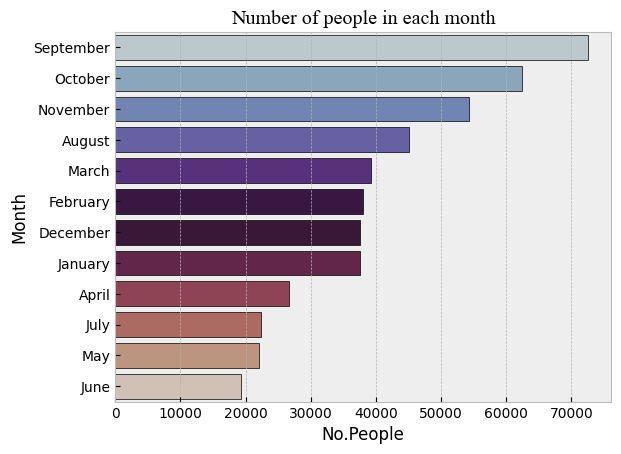

In [79]:
sns.barplot(x=p_m.values,y=p_m.index,edgecolor="k",palette='twilight')
plt.title("Number of people in each month",fontfamily='times new roman')
plt.xlabel('No.People')
plt.ylabel('Month')
plt.show()

<m>

### 2.3 Number of people in each season

<m>

In [80]:
s_p=df.groupby('season').number_people.sum().sort_values(ascending=False)
s_p

season
Fall      189149
Winter    113152
Spring     88099
Summer     86623
Name: number_people, dtype: int64

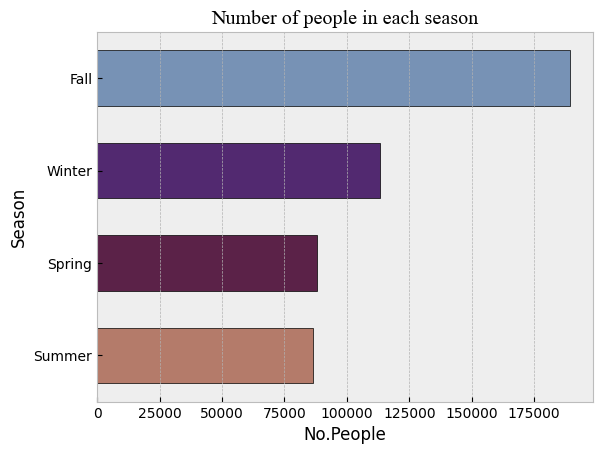

In [81]:
sns.barplot(x=s_p.values,y=s_p.index,edgecolor="k",palette='twilight',width=0.6)
plt.title("Number of people in each season",fontfamily='times new roman')
plt.xlabel('No.People')
plt.ylabel('Season')
plt.show()

<m>

### 2.4 Number of people in each week days

<m>

In [82]:
w_p=df.groupby('day_name').number_people.sum().sort_values(ascending=False)
w_p

day_name
Monday       79633
Tuesday      79070
Sunday       73682
Wednesday    72994
Thursday     72975
Friday       53350
Saturday     45319
Name: number_people, dtype: int64

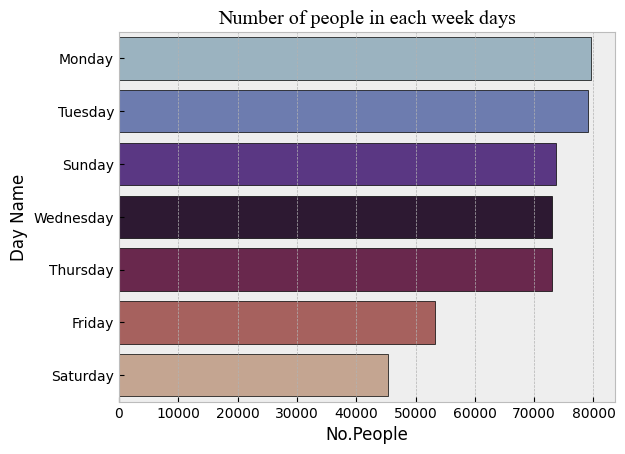

In [83]:
sns.barplot(x=w_p.values,y=w_p.index,edgecolor="k",palette='twilight')
plt.title("Number of people in each week days",fontfamily='times new roman')
plt.xlabel('No.People')
plt.ylabel('Day Name')
plt.show()

<m>

### 2.5 Number of people during the day

<m>

In [84]:
h_p=df.groupby('hour').number_people.sum().sort_values(ascending=False)
h_p

hour
11AM    101089
10AM     94320
9AM      84502
8AM      67304
12PM     60126
7AM      42962
6AM      24169
5AM       2551
Name: number_people, dtype: int64

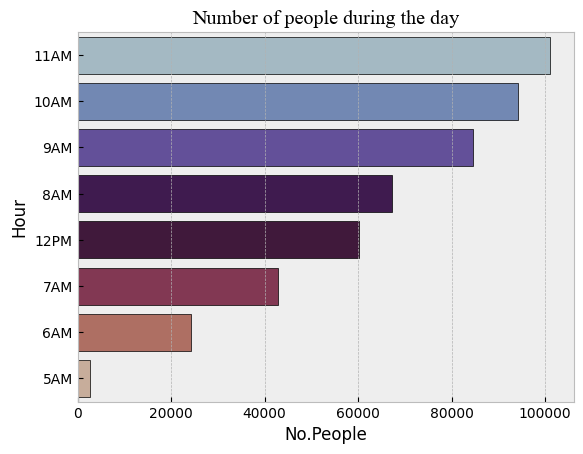

In [85]:
sns.barplot(x=h_p.values,y=h_p.index,edgecolor="k",palette='twilight')
plt.title("Number of people during the day",fontfamily='times new roman')
plt.xlabel('No.People')
plt.ylabel('Hour')
plt.show()

<m>

### 2.6 Relation between number of people and holiday

<m>

In [86]:
ho_p=df.groupby('holiday').number_people.mean().sort_values(ascending=False)
ho_p=round(ho_p,0)
ho_p

holiday
No     23.0
Yes     4.0
Name: number_people, dtype: float64

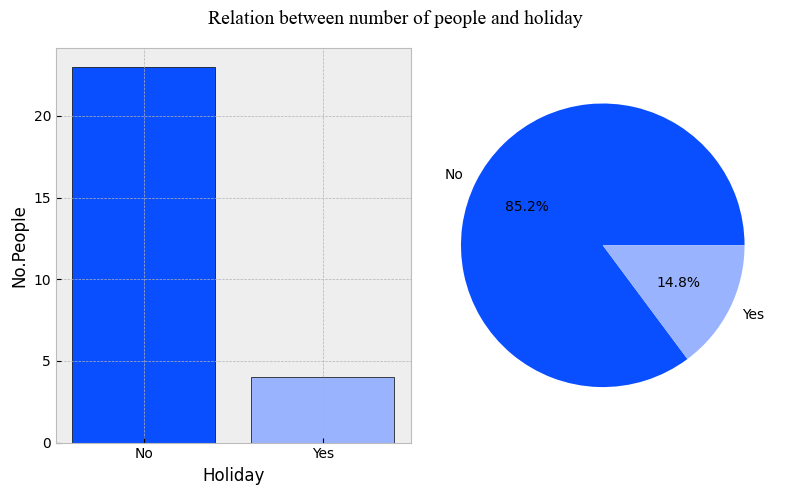

In [87]:
colors=['#0A4FFF','#99B3FF']
fig,axis=plt.subplots(nrows=1,ncols=2,figsize=(8,5))
axis[0].bar(ho_p.index,ho_p.values,edgecolor='k',color=colors)
axis[0].set_xlabel('Holiday')
axis[0].set_ylabel('No.People')
axis[1].pie(ho_p.values,labels=ho_p.index,autopct='%1.1f%%',colors=colors)
fig.suptitle("Relation between number of people and holiday", fontsize=14,fontfamily='times new roman')
plt.tight_layout()
plt.show()

<m>

### 2.7 Relation between number of people and weekend

<m>

In [88]:
we_p=df.groupby('weekend').number_people.mean().sort_values(ascending=False)
we_p=round(we_p,0)
we_p

weekend
No     25.0
Yes    17.0
Name: number_people, dtype: float64

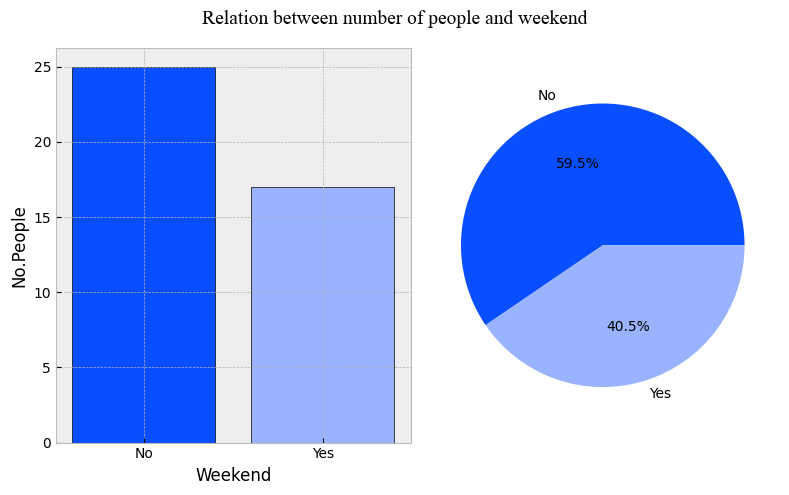

In [89]:
colors=['#0A4FFF','#99B3FF']
fig,axis=plt.subplots(nrows=1,ncols=2,figsize=(8,5))
axis[0].bar(we_p.index,we_p.values,edgecolor='k',color=colors)
axis[0].set_xlabel('Weekend')
axis[0].set_ylabel('No.People')
axis[1].pie(we_p.values,labels=we_p.index,autopct='%1.1f%%',colors=colors)
fig.suptitle("Relation between number of people and weekend", fontsize=14,fontfamily='times new roman')
plt.tight_layout()
plt.show()

<m>

### 2.8 Relation between number of people and start of semester

<M>

In [90]:
ss_p=df.groupby('start_semester').number_people.mean().sort_values(ascending=False)
ss_p=round(ss_p,0)
ss_p

start_semester
Yes    36.0
No     22.0
Name: number_people, dtype: float64

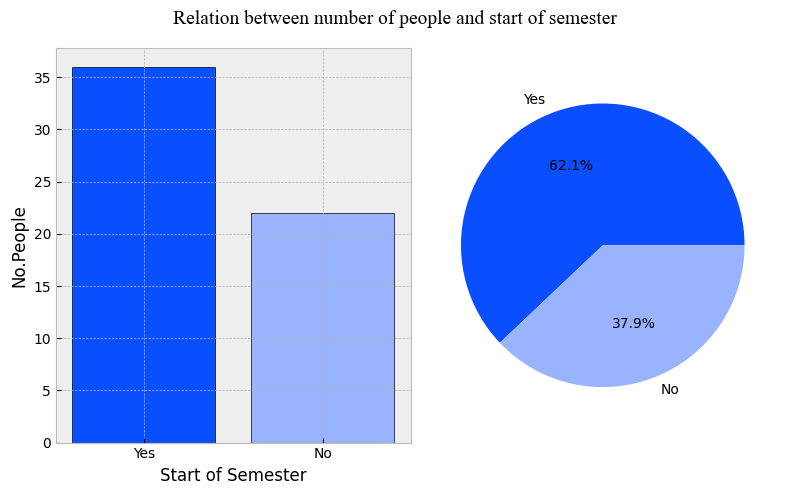

In [91]:
colors=['#0A4FFF','#99B3FF']
fig,axis=plt.subplots(nrows=1,ncols=2,figsize=(8,5))
axis[0].bar(ss_p.index,ss_p.values,edgecolor='k',color=colors)
axis[0].set_xlabel('Start of Semester')
axis[0].set_ylabel('No.People')
axis[1].pie(ss_p.values,labels=ss_p.index,autopct='%1.1f%%',colors=colors)
fig.suptitle("Relation between number of people and start of semester", fontsize=14,fontfamily='times new roman')
plt.tight_layout()
plt.show()

<m>

### 2.9 Relation between number of people and during of semester

<m>

In [92]:
ds_p=df.groupby('start_semester').number_people.mean().sort_values(ascending=False)
ds_p=round(ss_p,0)
ds_p

start_semester
Yes    36.0
No     22.0
Name: number_people, dtype: float64

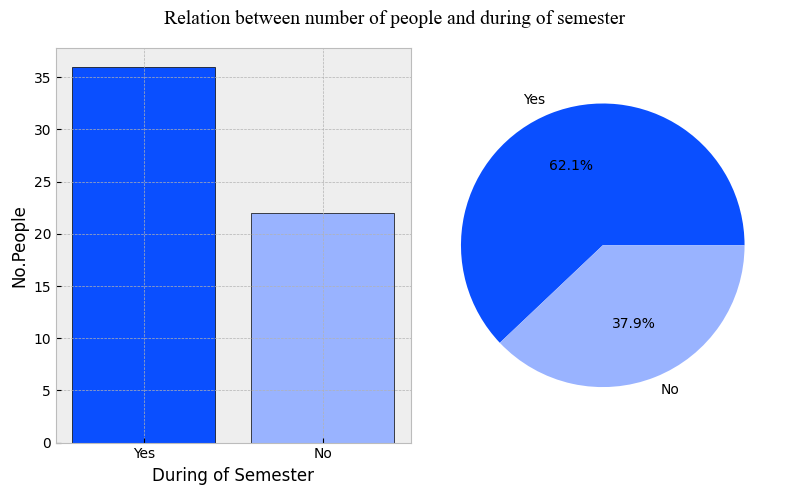

In [93]:
colors=['#0A4FFF','#99B3FF']
fig,axis=plt.subplots(nrows=1,ncols=2,figsize=(8,5))
axis[0].bar(ds_p.index,ds_p.values,edgecolor='k',color=colors)
axis[0].set_xlabel('During of Semester')
axis[0].set_ylabel('No.People')
axis[1].pie(ds_p.values,labels=ds_p.index,autopct='%1.1f%%',colors=colors)
fig.suptitle("Relation between number of people and during of semester", fontsize=14,fontfamily='times new roman')
plt.tight_layout()
plt.show()

<m>

### 2.10 Relation between number of people and temperature

<m>

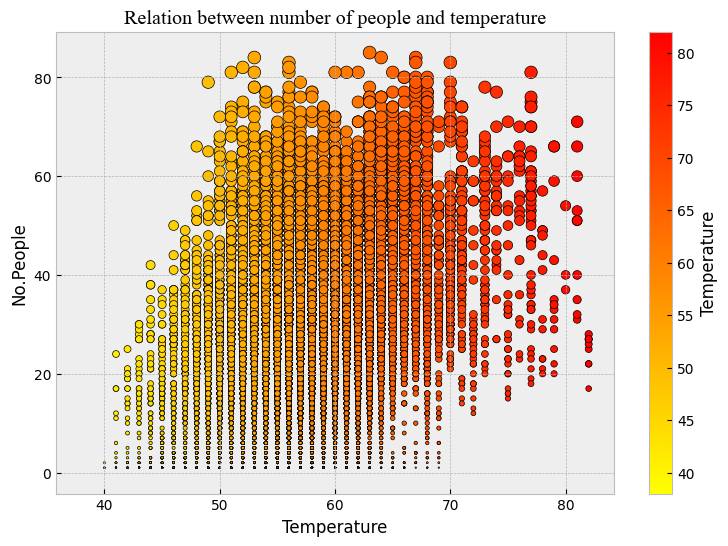

In [94]:
plt.figure(figsize=(9,6))
plt.scatter(df['temperature'],df['number_people'],c=df['temperature'],s=df['number_people'],cmap='autumn_r',edgecolor='k',label='Tempreture')
plt.title("Relation between number of people and temperature",fontfamily="times new roman")
plt.xlabel('Temperature')
plt.ylabel('No.People')
cbar=plt.colorbar()
cbar.set_label('Temperature')
plt.show()

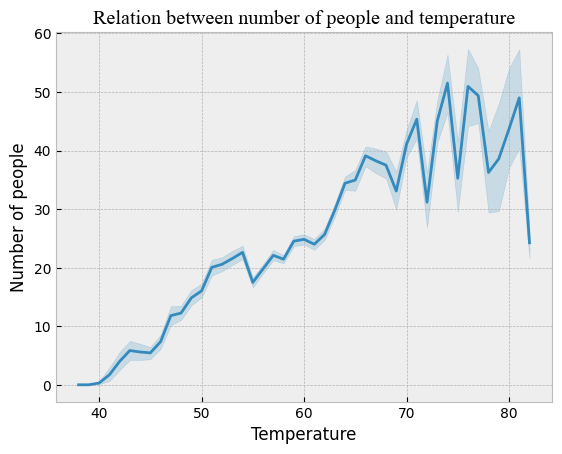

In [95]:
sns.lineplot(x=df["temperature"],y=df["number_people"],data=df,linewidth=2)
plt.title("Relation between number of people and temperature",fontfamily="times new roman")
plt.xlabel("Temperature")
plt.ylabel("Number of people")
plt.show()